In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("rise.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input\1_gFC2bTg3uihp1klknWU0qg.gif
../input\airline_passengers.csv
../input\AirQualityUCI.zip
../input\macrodata.csv
../input\operations.csv.zip
../input\Summary of Weather.csv.zip
../input\time-series-prediction-tutorial-with-eda.ipynb
../input\Weather Station Locations.csv
../input\AirQualityUCI\AirQualityUCI.csv
../input\AirQualityUCI\AirQualityUCI.xlsx
../input\demand_store_forecast\train.csv
../input\operations\operations.csv
../input\Summary of Weather\Summary of Weather.csv


# Introduction

In this kernel, the essentials of the time series analysis is demonstrated. The datasets used is the US macroeconmic data and Airline passengers data.  

- Hodrick Prescott filter to separate the trend and cyclic components 
- Error, Trend and Seasonality Decomposition using Statsmodels Seasonal Decomposition
- Exponential Smoothing using Pandas EWMA and Holt Winters method for Single, Double and Triple Exponential           Smoothing
- Forecast into the real future using Holt Winters triple exponential method

Credit Source: <a> link: "https://www.kaggle.com/prakharprasad/smoothing-holt-winters-forecast/data?select=macrodata.csv" </a>

## Part I - Time Series Decomposition

### Import Libraries
Note the statsmodels specific libraries used in this kernel. 
  

In [12]:
# arrays and dataframes
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# time series - statsmodels
from statsmodels.tsa.filters.hp_filter import hpfilter  # Hodrick Prescott filter for cyclic & trend separation
from statsmodels.tsa.seasonal import seasonal_decompose # Error Trend Seasonality decomposition

# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

# consistent plot size wherever not specifiied
from pylab import rcParams
rcParams['figure.figsize'] = (15,8)

# Hodrick Prescott Filter
The Hodrick Prescott filter is used to <span style="color:#20419a">separate the trend and cyclical component </span> from the time series data. The components are determined by <u><b>minimising the quadratic loss function </b></u> where an important element is `lambda` which is the smoothing parameter. The recommended value of <span style="color:#20419a">lambda is 1600 </span> when analyzing quarterly data, <span style="color:#20419a">6.25 for yearly data</span> and 129,600 for monthly data. <p> Removing the cyclic component essentially, makes the data sensitive to long term fluctuations and not to the short term fluctuations. This is especially important for analyzing the GDP. 

Read more about Hodrick Prescott filter here https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter#:~:text=The%20Hodrick%E2%80%93Prescott%20filter%20(also,time%20series%20from%20raw%20data.


In [7]:
# US Macro economic data
usmacro = pd.read_csv('../input/macrodata.csv',index_col=0,parse_dates=True)

In [8]:
usmacro.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


Any of the columns can be explored and used for time series analysis. But first we will visualize one of the columns - realgdp

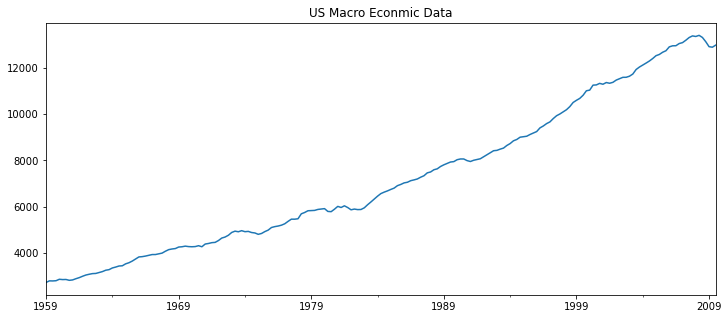

In [9]:
# visualize the realgdp --- > will use the capabilities of pandas plotting capability
usmacro['realgdp'].plot(figsize=(12,5),title='US Macro Econmic Data').autoscale(axis='x',tight=True)

The trend and cycles can be separated using tuple unpacking using the `hpfilter` function

In [10]:
# tuple unpacking, lambda as 1600 to analyze the quarterly trend 
cycles,trend = hpfilter(usmacro['realgdp'],lamb=1600) 

We will add trend as an additional column in the data frame -- makes plotting easier with pandas

In [11]:
usmacro['gdp_trend'] = trend
usmacro['gdp_cycles'] = cycles

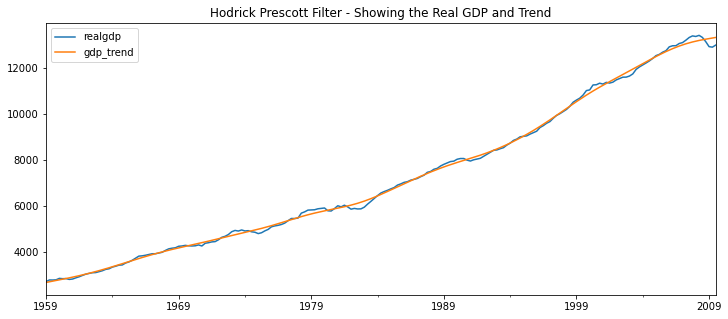

In [12]:
usmacro[['realgdp','gdp_trend']].plot(figsize=(12,5),title='Hodrick Prescott Filter - Showing the Real GDP and Trend').autoscale(axis='x',tight=True)

Now we have the GDP trend which is sensitive to the long term fluctuations and not to the short term fluctuations. This makes more sense for analysing the business life cycle over a well defined period. Similarly, the trend can be analyzed by varying the values of lambda to check for annual and monthly trend. 

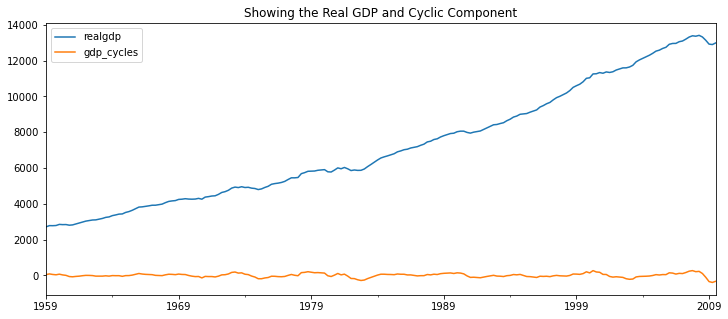

In [13]:
# Plot the cyclic component
usmacro[['realgdp','gdp_cycles']].plot(figsize=(12,5),title='Showing the Real GDP and Cyclic Component').autoscale(axis='x',tight=True)

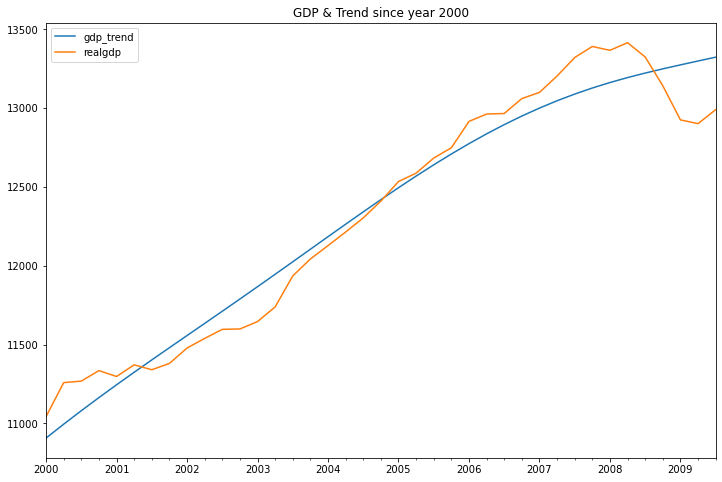

In [14]:
# Lets check this out since year 2000
usmacro[['gdp_trend','realgdp']]['2000-03-31':].plot(figsize=(12,8),title='GDP & Trend since year 2000').autoscale(axis='x',tight=True);

## ETS - Error, Trend and Seasonality Decomposition

The decomposition of a time series attempts to isolate individual components such as error, trend and seasonality. `Statsmodels` provided *seasonal decomposition* tool to separate out the different components. <p> To demonstrate the seasonal decomposition capability of statsmodels, I will make use of the airline passenger data.

Remember - Additive model is used when the trend component is more constant over time. Example, every year 20,000 passengers are added. Multiplicative model is used when the trend increases/decreases at a non linear rate. example, every year the number of airline passengers doubles by 20,000.

In [3]:
airline = pd.read_csv('../input/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
airline['Thousands of Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Thousands of Passengers, Length: 144, dtype: int64

In [8]:
# decompose the time series
decompose_result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

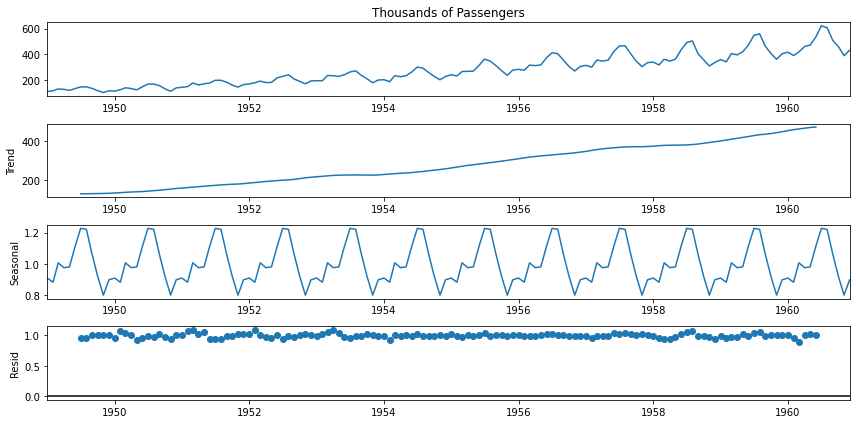

In [9]:
fig = decompose_result.plot()
plt.show()

Tip: Sometimes, the plot gets plotted twice. To get rid of this, just use a semi-colon at the end of the plot. 

So here we see the original graph, the trend, seasonal and the residual or the error.

# Part II - Fit various smoothing models to existing data

# Moving Averages

## SMA - Simple Moving Averages

In [10]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
airline.dropna(inplace=True)

Create Moving Average 6 months using the `rolling(window)` and `mean` function. 

In [24]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()

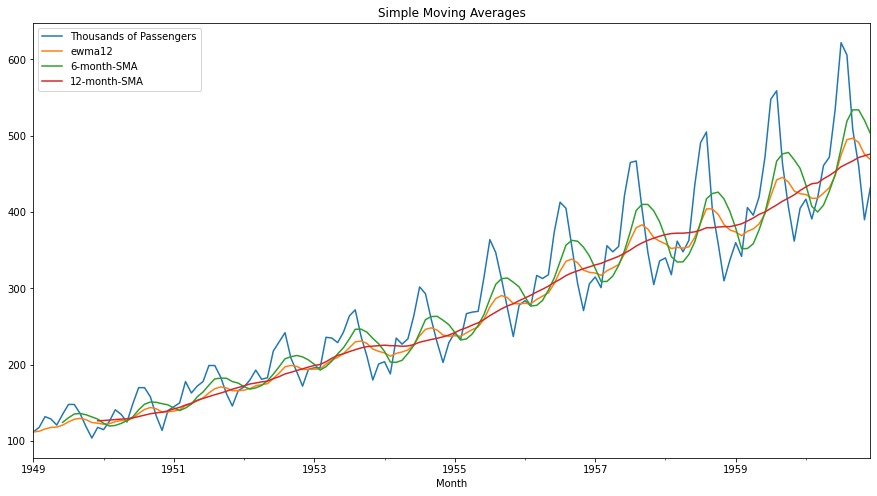

In [25]:
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.plot(title='Simple Moving Averages');

Note that rolling introduces the NaN depending on the window size selected. However there are some disadvantages of simple moving average
- Smaller windows will lead to more noise, rather than signal
- It will always lag by the size of the window (see the MA starts after a certain lag above in the figure)
- It will never reach to full peak or valley of the data due to the averaging.
- Does not really inform you about possible future behavior, all it really does is describe trends in your data.
- Extreme historical values can skew your SMA significantly

To help fix some of these problems, we have the EWMA or the Exponentially Weighted Moving Average

In [18]:
airline.head(12)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500000,NaN
1949-07-01,148,130.500000,NaN
1949-08-01,148,135.500000,NaN
1949-09-01,136,136.166667,NaN


## EWMA - Exponentially Weighted Moving Average
EWMA alows to reduce the lag by putting more weight to the recent readings or values. The <span style="color:blue">amount of weight</span> applied is dependent on the <span style="color:lightgreen">actual parameters in the EWMA</span> and the <span style="color:lightgreen">number of periods given in a window size.</span> 
<p>
More information can be found here https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

Note: EWMA applies Single Exponential Smoothing.Function `ewm`.

In [14]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [21]:
airline['ewma12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

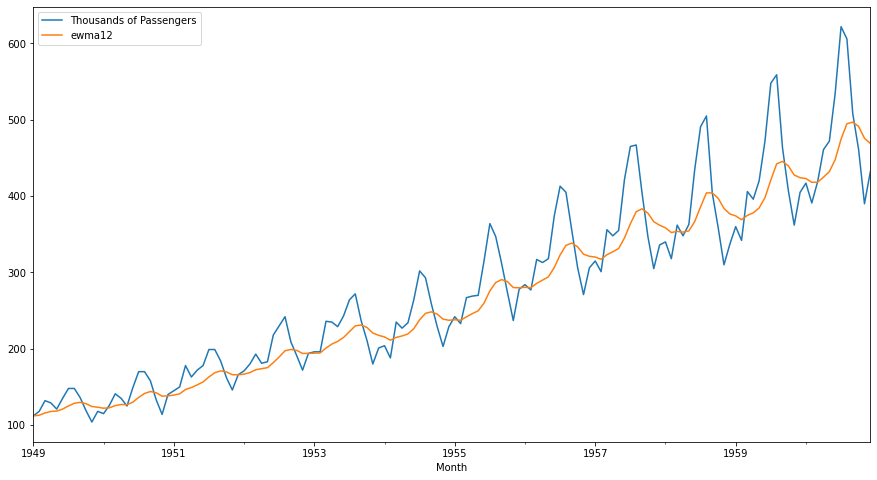

In [22]:
airline[['Thousands of Passengers','ewma12']].plot();

## Comparing SMA to EWMA

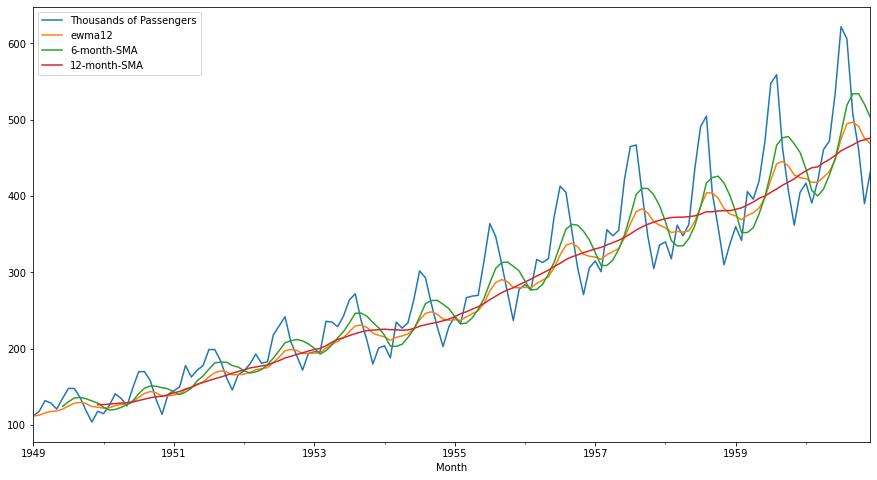

In [26]:
airline[['Thousands of Passengers','ewma12','6-month-SMA','12-month-SMA']].plot();

## Holt Winters - Simple, Double and Triple Exponential Smoothing

Moving Averages and Single Exponential Smoothing does a poor job of forecasting when there is trend and seasonality in the data. Double and Triple exponential smoothing is best suited for this kind of time-series data. 
<p> Holt winters has all the three variations - <span style="color:red"> Single, Double and Triple exponential smoothing. </span>
<p> Double Exponential smoothing uses a smoothing factor that addresses <span style="color:blue">trend</span>. Triple Exponential smoothing uses a smoothing factor that addresses <span style="color:blue">seasonality.<span>

<p> Span corresponds to what is commonly called an <i>“N-day EW moving average”</i>. Alpha specifies the smoothing factor 
directly.</p>

Refer https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows

In [30]:
# set the span and the smoothing factor alpha
span = 12
alpha = 2/(span+1)

In [31]:
airline.columns

Index(['Thousands of Passengers', 'ewma12', '6-month-SMA', '12-month-SMA'], dtype='object')

To work with forecasting models like Holt Winters, ARIMA, SARIMA etc., the datetime index frequency needs to be set. The Airline passenger dataset index indicates dates on the start of the month. Hence we can set this as 'MS'

In [32]:
# Set the frequency of the date time index as Monthly start as indicated by the data
airline.index.freq = 'MS' 

In [33]:
airline.head()

,Thousands of Passengers,ewma12,6-month-SMA,12-month-SMA
Month,,,,
1949-01-01,112,112.000000,NaN,NaN
1949-02-01,118,112.923077,NaN,NaN
1949-03-01,132,115.857988,NaN,NaN
1949-04-01,129,117.879836,NaN,NaN
1949-05-01,121,118.359861,NaN,NaN


In [34]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

## Simple Exponential Smoothing - Using Holt Winters
This is same as `ewm` method in Pandas. For simple exponential smoothing, the function is called `SimpleExpSmoothing`.

In [35]:
airline['SES12'] = SimpleExpSmoothing(airline['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


NOTE: For some reason, when optimized=False is passed into .fit(), the statsmodels SimpleExpSmoothing function shifts fitted values down one row. We fix this by adding .shift(-1) after .fittedvalues

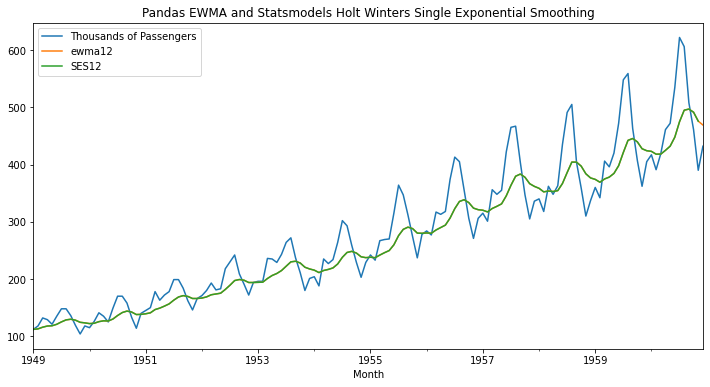

In [30]:
airline[['Thousands of Passengers','ewma12','SES12']].plot(title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing');                       

In [29]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12
Month,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000
1949-02-01,118,NaN,NaN,112.923077,112.923077
1949-03-01,132,NaN,NaN,115.857988,115.857988
1949-04-01,129,NaN,NaN,117.879836,117.879836
1949-05-01,121,NaN,NaN,118.359861,118.359861


Both the EWMA and Holt Winters Single Exponential Smoothing curve fit each other completely. 

## Double Exponential Smoothing

In [37]:
airline['DES12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add').fit().fittedvalues.shift(-1)

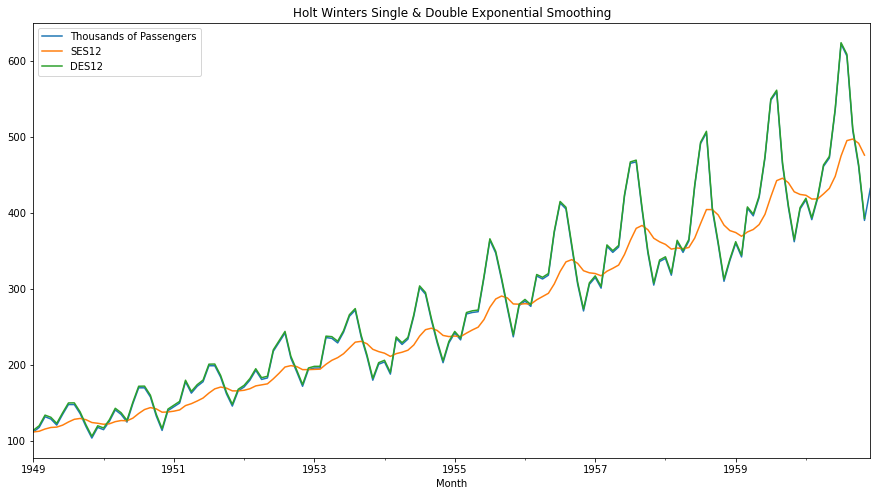

In [39]:
airline[['Thousands of Passengers','SES12','DES12']].plot(title='Holt Winters Single & Double Exponential Smoothing');

Here the double exponential smoothing completely overlaps on the original data. Let's plot for the last 24 months.

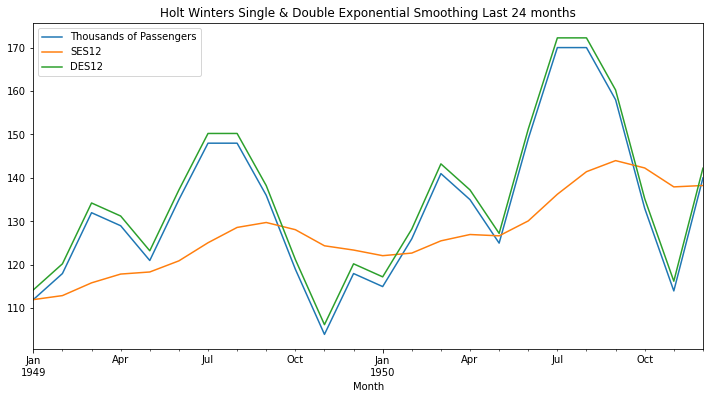

In [33]:
airline[['Thousands of Passengers','SES12','DES12']].iloc[:24].plot(title='Holt Winters Single & Double Exponential Smoothing Last 24 months').autoscale(axis='x',tight=True);

Lets replot the above using the multiplicative adjustment instead of additive.

In [34]:
airline['DES12_mul'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul').fit().fittedvalues.shift(-1)

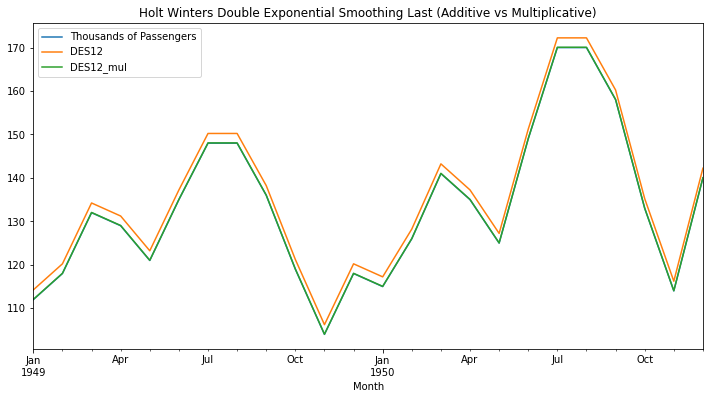

In [35]:
airline[['Thousands of Passengers','DES12','DES12_mul']].iloc[:24].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

Although minor, the multiplicative adjustment gives a better result compared to the additive adjustment for the trend.

## Triple Exponential Smoothing 

In [38]:
airline['TESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [39]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,DES12,DES12_mul,TESadd12
Month,,,,,,,,
1949-01-01,112,NaN,NaN,112.000000,112.000000,114.23775,112.049247,113.081289
1949-02-01,118,NaN,NaN,112.923077,112.923077,120.23775,118.051885,120.550769
1949-03-01,132,NaN,NaN,115.857988,115.857988,134.23775,132.058041,135.527364
1949-04-01,129,NaN,NaN,117.879836,117.879836,131.23775,129.056722,133.155107
1949-05-01,121,NaN,NaN,118.359861,118.359861,123.23775,121.053204,125.656165


In [41]:
airline['TESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

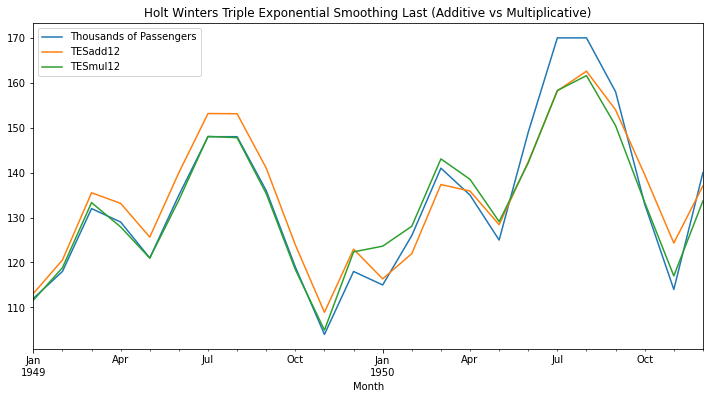

In [42]:
airline[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

# Part III - Forecasting with Holt Winters Method

Lets read the airline data again to have a fresh copy

In [41]:
airline  = pd.read_csv('../input/airline_passengers.csv',index_col='Month',
                      parse_dates=True)

In [42]:
airline.index.freq = 'MS'

In [43]:
airline.index # Get the index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [44]:
airline.tail() # Last 5 rows of airline Series

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [45]:
# Number of months of data 
len(airline)

144

### Split into training and test set
It is important to remember that the time-series are dependent on time, hence it is wise to split train test by sequence. 
<span style = "color:#00a19C"> ORDER MATTERS! </span>

In [46]:
# Split into 75% train and 25% test set. Remember that sequence matters in time-series forecasting!
train_airline = airline[:108] 
test_airline = airline[108:] 

In [47]:
len(test_airline)

36

### Fit the model on the train set
Seasonal periods with value <b>12<b> indicates the seasonality we expect in the data. for airline passenger we can safely assume that the <u>seasonality would repeat every 12 months.</u>

In [48]:
# Fit Exponential Smoothing
fitted_model = ExponentialSmoothing(train_airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [49]:
test_predictions = fitted_model.forecast(36).rename('HW Test Forecast')

In [50]:
test_predictions[:10]

1958-01-01    356.968595
1958-02-01    344.588791
1958-03-01    405.718334
1958-04-01    400.610841
1958-05-01    409.001673
1958-06-01    480.694167
1958-07-01    530.470025
1958-08-01    523.288484
1958-09-01    454.210536
1958-10-01    392.518080
Freq: MS, Name: HW Test Forecast, dtype: float64

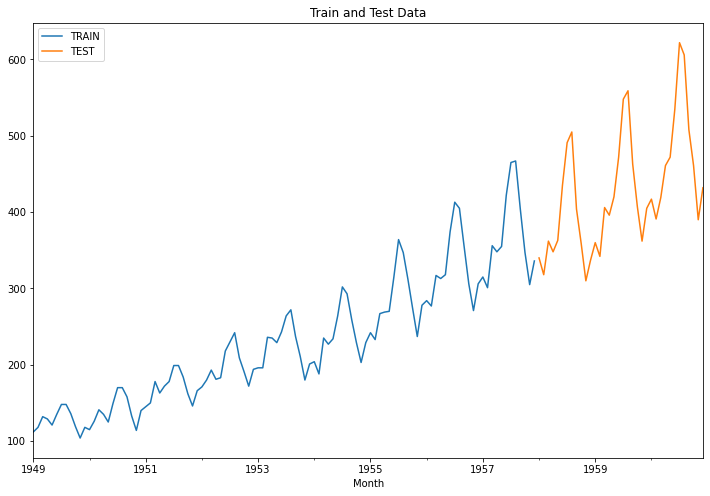

In [51]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
plt.title('Train and Test Data');

Next we will plot also the predicted test data

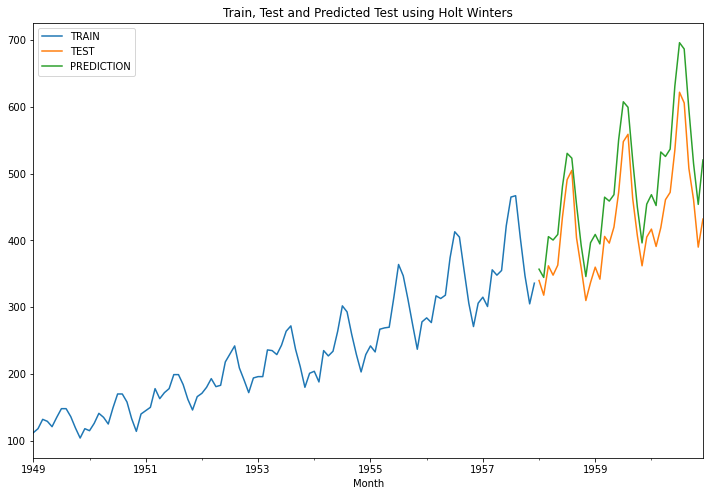

In [52]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

Plot for the recent rows

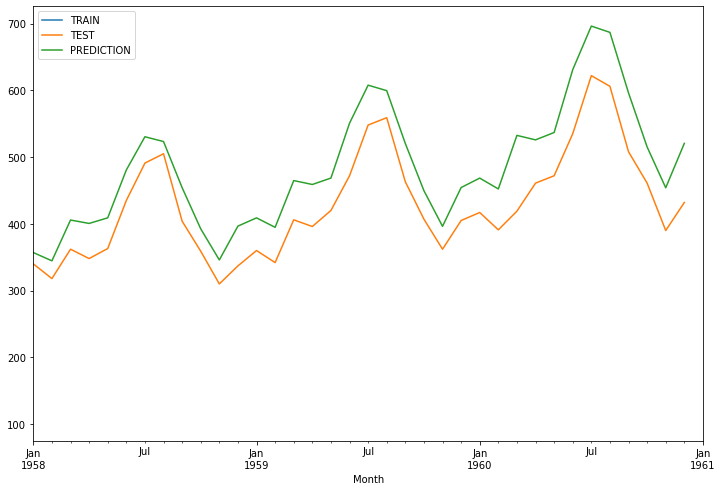

In [53]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

### Evaluation metrics

In [54]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [55]:
print(f'Mean Absolute Error = {mean_absolute_error(test_airline,test_predictions)}')

Mean Absolute Error = 55.697947931677795


In [56]:
print(f'Mean Squared Error = {mean_squared_error(test_airline,test_predictions)}')

Mean Squared Error = 3525.8835849096904


In [57]:
test_airline.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


The predictions are not as bad as I thought earlier. The MAE is very less compared to the mean of the true test data. So not a bad job till now. 

### Forecast into the future
Till now, we predicted the test values and compared with the true test values. The true forecast can only be once it is done for the real future !!

We will use the <b>Holt-Winter Multiplicative Model</b> with annual seasonality as the final model.

In [58]:
final_model = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
C:\Users\crystallwi.xiaujing\AppData\Local\Continuum\anaconda3\envs\env01\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Use the `forecast` function to forecast the Airline Passengers for the next 36 months. 

In [59]:
forecast_predictions = final_model.forecast(steps=36)

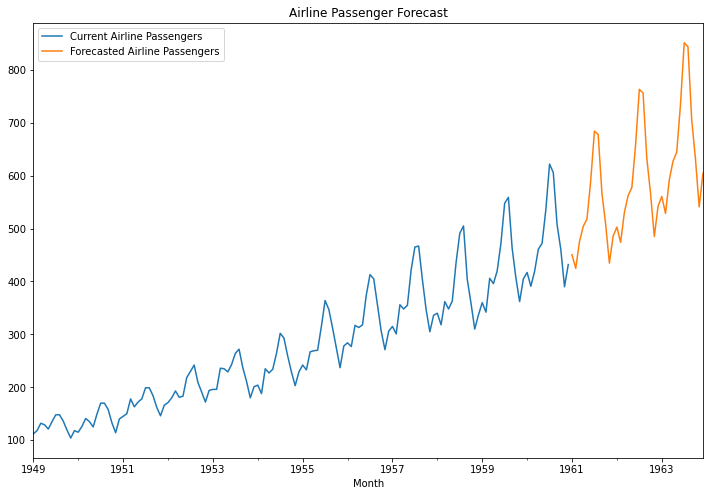

In [60]:
airline['Thousands of Passengers'].plot(figsize=(12,8),legend=True,label='Current Airline Passengers')
forecast_predictions.plot(legend=True,label='Forecasted Airline Passengers')
plt.title('Airline Passenger Forecast');

## END